Data Generation

In [ ]:
!pip install captcha pillow seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 4.1 MB/s eta 0:00:00


In [4]:
import argparse
import json
import random
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha

import itertools

FLAGS = None
META_FILENAME = 'meta.json'


def get_choices():
    choices = [
        (True, map(str, range(10))),
        ]
    return tuple([i for is_selected, subset in choices for i in subset if is_selected])


def _gen_captcha(img_dir, num_per_image, n, width, height, choices, max_images_count):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    remain_count = max_images_count
    epoche_count = len(list(itertools.permutations(choices, num_per_image)))

    print('generating %s epoches of captchas in %s.' % (n, img_dir))

    for _ in range(n):
        samples = itertools.permutations(choices, num_per_image)
        if remain_count > 0 and remain_count < epoche_count:
            print('only %s records used in epoche %s. epoche_count: %s' % (remain_count, _+1, epoche_count))
            samples = random.sample(list(samples), remain_count)

        for i in samples:
            captcha = ''.join(i)
            fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
            image.write(captcha, fn)
        if n < 20:
            print('(%s/%s) epoches finished' % (_+1, n))


def build_file_path(x):
    return os.path.join(r"/content/images/", 'char-%s-epoch-%s' % (4, 2), x)


def gen_dataset():
    n_epoch = 100
    num_per_image = 4
    test_ratio = 0
    max_images_count = 0

    choices = get_choices()

    width = 40 + 20 * num_per_image
    height = 100

    # meta info
    meta = {
        'num_per_image': num_per_image,
        'label_size': len(choices),
        'label_choices': ''.join(choices),
        'n_epoch': n_epoch,
        'width': width,
        'height': height,
    }

    print('%s choices: %s' % (len(choices), ''.join(choices) or None))

    _gen_captcha(build_file_path('train'), num_per_image, n_epoch, width, height, choices=choices, max_images_count=max_images_count)

    if test_ratio > 0:
        _gen_captcha(build_file_path('test'), num_per_image, max(1, int(n_epoch * test_ratio)), width, height, choices=choices, max_images_count=max(1, int(max_images_count * test_ratio)))

    meta_filename = build_file_path(META_FILENAME)
    with open(meta_filename, 'w') as f:
        json.dump(meta, f, indent=4)
    print('write meta info in %s' % meta_filename)

gen_dataset()

10 choices: 0123456789
generating 100 epoches of captchas in /content/images/char-4-epoch-2/train.


KeyboardInterrupt: ignored

In [5]:
import PIL
import os
import os.path
from PIL import Image

f = r'/content/images/char-4-epoch-2/train'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    img = img.resize((54,22))
    img.save(f_img)

Actual Code

In [15]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import os
import time
import json
import glob

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

tf.__version__

'2.12.0'

# Data Preview

In [16]:
# !python3 datasets/gen_captcha.py -d --npi=4 -n 6
# !python3 datasets/base.py ./images/char-4-epoch-6/

In [17]:
DATA_DIR = '/content/images/char-4-epoch-2/train'
H, W, C = 22, 54, 3  # height, width, 3(RGB channels)
N_LABELS = 256
D = 4 # num_per_image

In [18]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [19]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.png"))
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.head()

,label,file
0,0172,/content/images/char-4-epoch-2/train/0172_23d6...
1,0573,/content/images/char-4-epoch-2/train/0573_92db...
2,5107,/content/images/char-4-epoch-2/train/5107_f744...
3,5703,/content/images/char-4-epoch-2/train/5703_c2fc...
4,9086,/content/images/char-4-epoch-2/train/9086_f2eb...


# Data Preprocessing

In [20]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.7)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 142614, valid count: 61121, test count: 87316


In [21]:
from tensorflow.keras.utils import to_categorical
from PIL import Image


def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(ord(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

# Model

In [22]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 22, 54, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 52, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 24, 64)         18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 12, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 10, 64)         3692

# Training

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=2,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/2
2228/2228 [==============================] - 117s 52ms/step - loss: 0.0188 - accuracy: 0.9939 - val_loss: 0.0637 - val_accuracy: 0.9855
Epoch 2/2
2228/2228 [==============================] - 112s 50ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0588 - val_accuracy: 0.9867


# Result Analysis

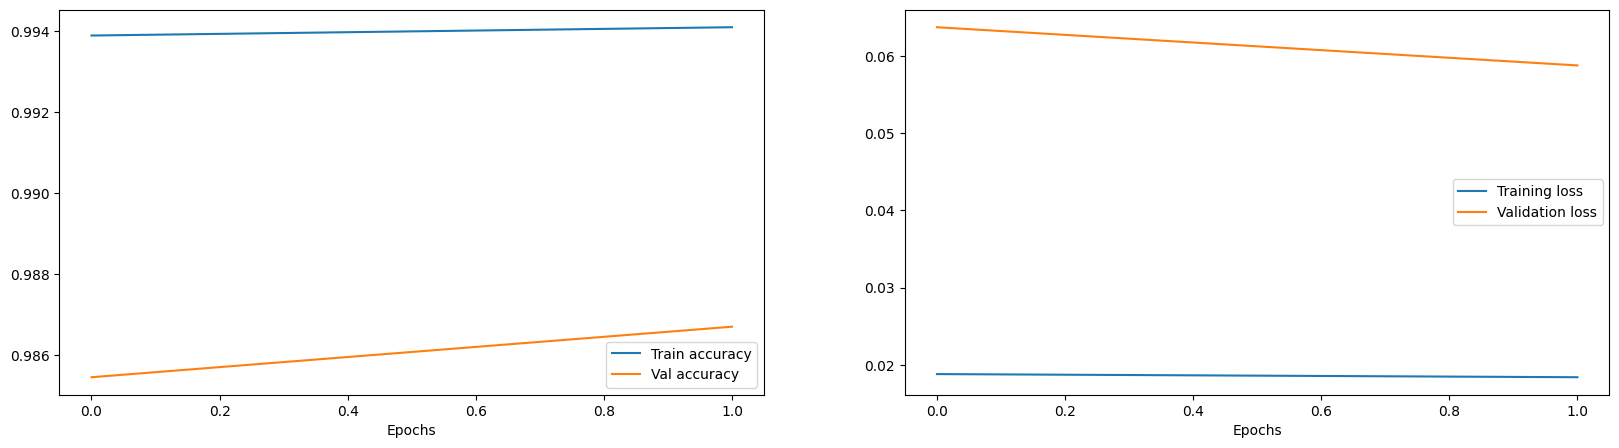

In [26]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)
plt.show()

In [27]:
# evaluate loss and accuracy in test dataset
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

682/682 [==============================] - 42s 61ms/step - loss: 0.0560 - accuracy: 0.9872


{'loss': 0.055960629135370255, 'accuracy': 0.9872159361839294}

# Predict and display result

In [48]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

print(x_test.shape)

(128, 22, 54, 3)


In [29]:
def format_y(y):
    return ''.join(map(lambda x: chr(int(x)), y))

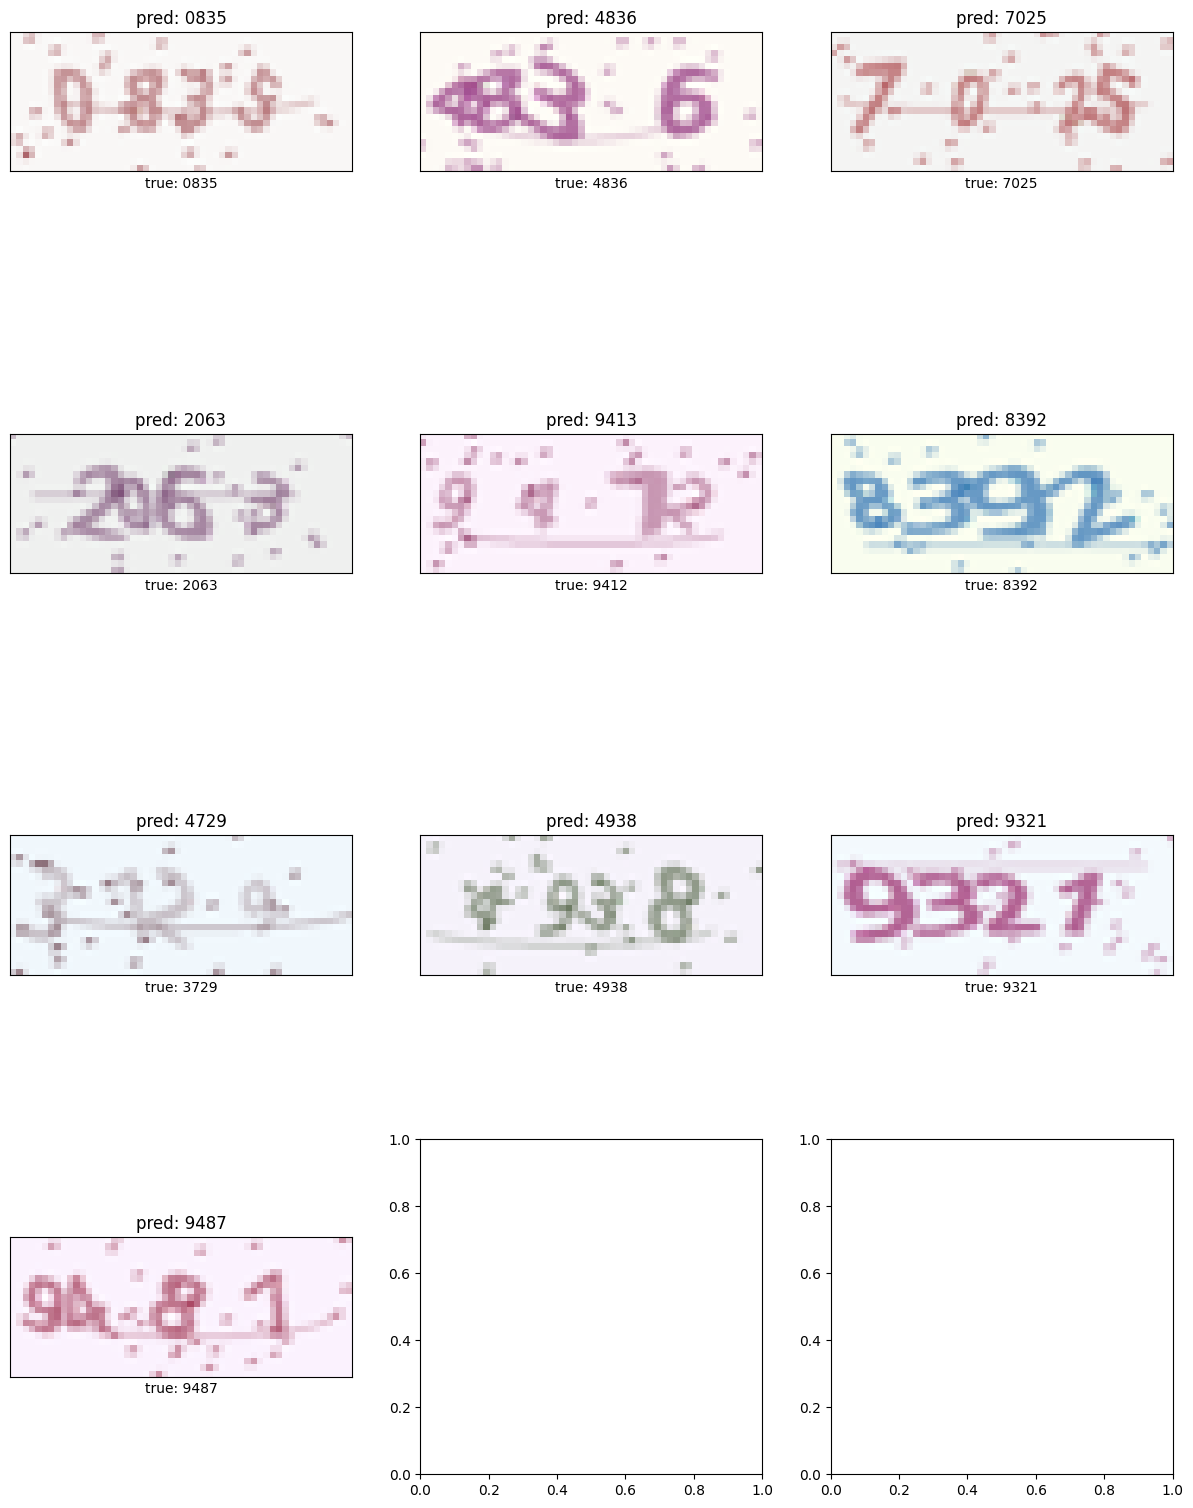

In [60]:
import math
n = 10
random_indices = np.random.permutation(n)
n_cols = 3
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: %s' % format_y(y_pred[img_idx]))
    ax.set_xlabel('true: %s' % format_y(y_true[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [34]:
model.save('saved_model/captcha_nd_9872')

In [36]:
!zip -r /content/model.zip /content/saved_model/captcha_nd_9872

  adding: content/saved_model/captcha_nd_9872/ (stored 0%)
  adding: content/saved_model/captcha_nd_9872/saved_model.pb (deflated 88%)
  adding: content/saved_model/captcha_nd_9872/keras_metadata.pb (deflated 91%)
  adding: content/saved_model/captcha_nd_9872/variables/ (stored 0%)
  adding: content/saved_model/captcha_nd_9872/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: content/saved_model/captcha_nd_9872/variables/variables.index (deflated 64%)
  adding: content/saved_model/captcha_nd_9872/assets/ (stored 0%)
  adding: content/saved_model/captcha_nd_9872/fingerprint.pb (stored 0%)


In [37]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 22, 54, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 52, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 24, 64)         18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 12, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 10, 64)         3692

In [54]:
test_img = Image.open("/content/2998.jpg")
# test_img = test_img.resize((24, 54))
test_img = np.array(test_img) / 255.0
print(test_img.shape)

(22, 54, 3)


In [55]:
test_img = test_img[np.newaxis,...]
print(test_img.shape)

(1, 22, 54, 3)


In [56]:
test_predi = model.predict(test_img)

1/1 [==============================] - 0s 222ms/step


In [57]:
print(test_predi)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [58]:
final_pred = tf.math.argmax(test_predi, axis=-1)